# ※ cats_vs_dogs 데이터셋 준비하기

[cats_vs_dogs from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### ▶ 사용 데이터셋 경로 변경: data_dir 사용

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

#(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'],
#                                         shuffle_files=True, as_supervised=True, with_info=True,
#                                         data_dir='~/aiffel/tensorflow_datasets')

(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], 
                                         as_supervised=True, shuffle_files=True, with_info=True)

- DatasetBuilder의 info(ds_info)를 통해 Feature 정보 확인 (ds_info.features)
  - 클래스 수와 클래스 이름 

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


- 데이터셋의 이미지 shape, 데이터 개수 확인

In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
print(tf.data.experimental.cardinality(ds_train).numpy())
print(tf.data.experimental.cardinality(ds_test).numpy())

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)
50000
10000


- cats_vs_dogs 데이터셋: 2개 클래스 확인
  - 클래스 구성, 이미지 확인

In [6]:
ds_info.features["label"].num_classes

10

In [7]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

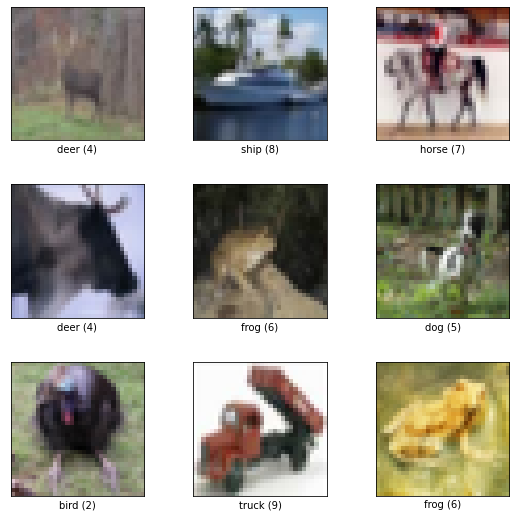

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

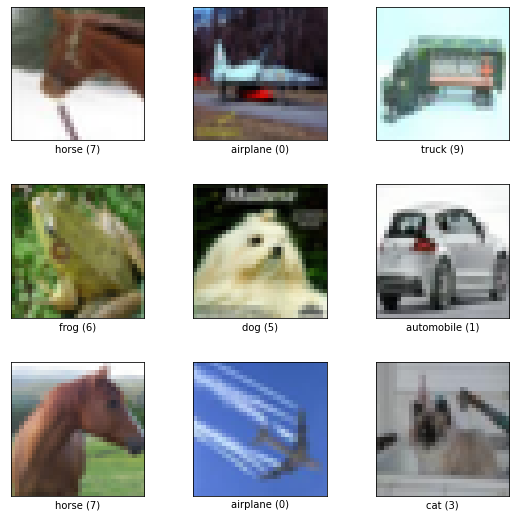

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

## ※ Input Normalization
- 각 채널별 최댓값인 255로 정규화(normalize): 이미지 표현값을 0과 1 사이로

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

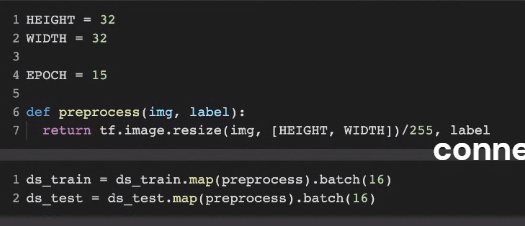


In [ ]:
#height = 224
#width = 224

#def preprocess(img, label):
#    return tf.image.resize(img, [height, width])/255, label

In [12]:
BATCH_SIZE=256

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#ds_train = ds_train.map(preprocess).batch(batch_size=BATCH_SIZE)
#ds_test = ds_test.map(preprocess).batch(batch_size=BATCH_SIZE)

- 모델 학습을 위한 데이터셋 확인 완료

# 2-7. 프로젝트: ResNet Ablation Study

## 0) 라이브러리 버전 확인하기

사용할 라이브러리 버전을 둘러봅시다.

In [13]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

## 1) ResNet 기본 블록 구성하기
- ResNet-34와 ResNet-50 네트워크 만들기
  - [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)  
  - [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)



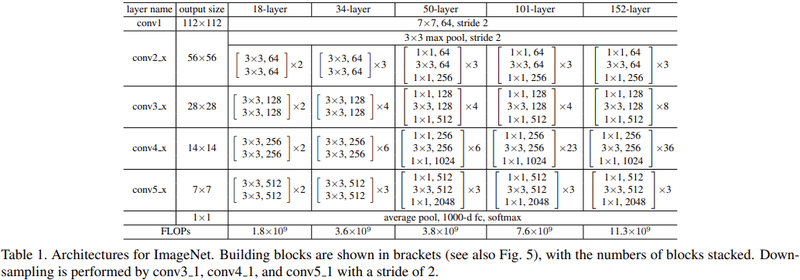

- ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.
  - ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점
    - ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성
    - ResNet-50은 1x1 Convolution이 앞뒤로 붙어 세 가지 다른 종류의 레이어로 구성 

### 분석 결과는 다음과 같다...

#### [Stage 1 & 2]
- ResNet-34의 경우 Stage #2의 첫 번째 블록이 Identity 블록이다.
- ResNet-50은 Projection 블록이다 (뒷 부분 참고).

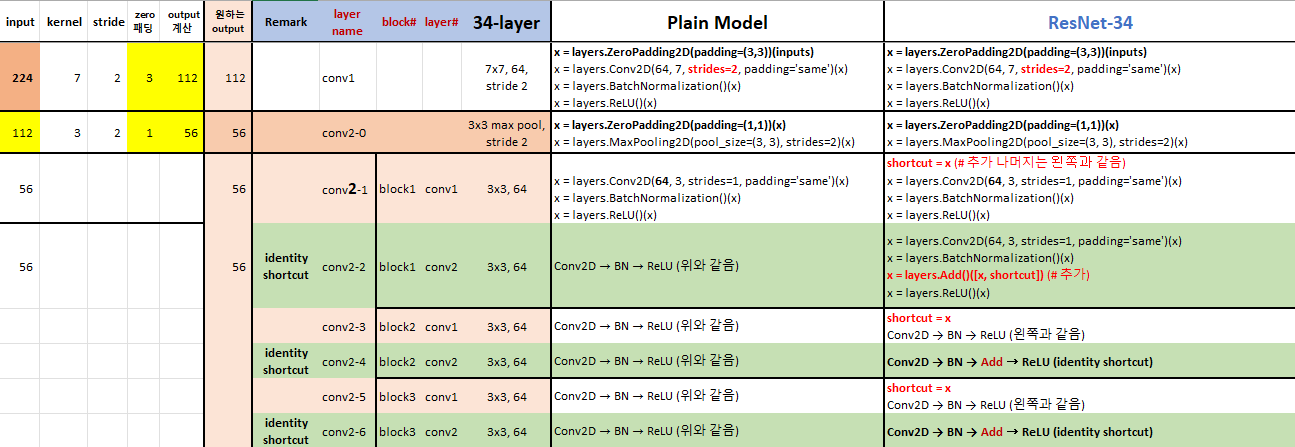

#### [Stage 3]
- ResNet-34의 경우 첫 번째 블럭 첫 번째 레이어로 제로패딩(x = layers.ZeroPadding2D(padding=(1,1))(x))이 필요하다.
- ResNet-50의 경우에는 필요없다 (뒷부분 참고).

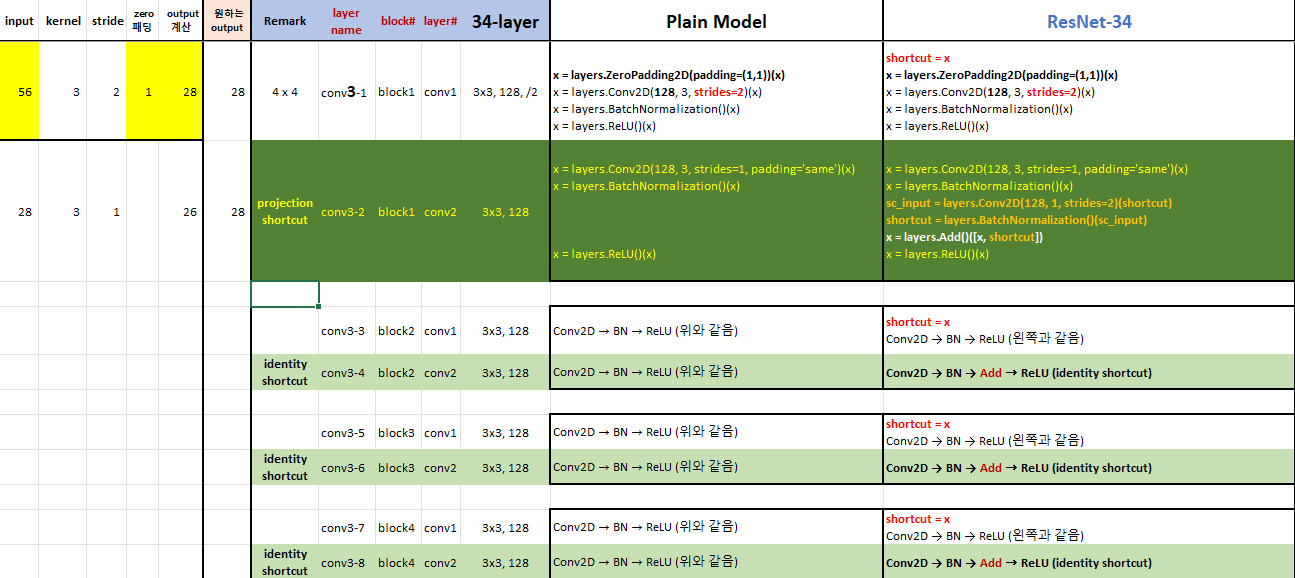

#### [Stage 4] 
- ResNet-34의 경우 첫 번째 블럭 첫 번째 레이어로 제로패딩(x = layers.ZeroPadding2D(padding=(1,1))(x))이 필요하다.
- ResNet-50의 경우에는 필요없다 (뒷부분 참고).


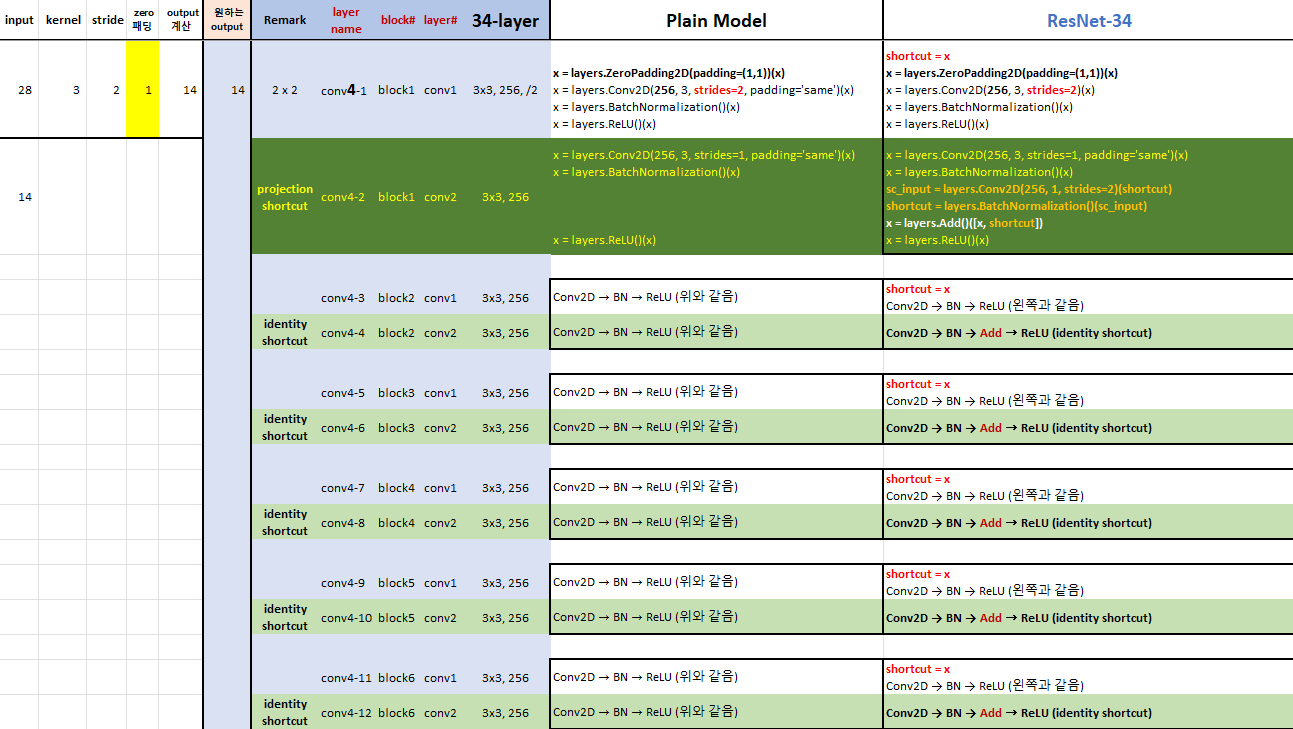

#### [Stage 5]
- ResNet-34의 경우 첫 번째 블럭 첫 번째 레이어로 제로패딩(x = layers.ZeroPadding2D(padding=(1,1))(x))이 필요하다.
- ResNet-50의 경우에는 필요없다 (뒷부분 참고).


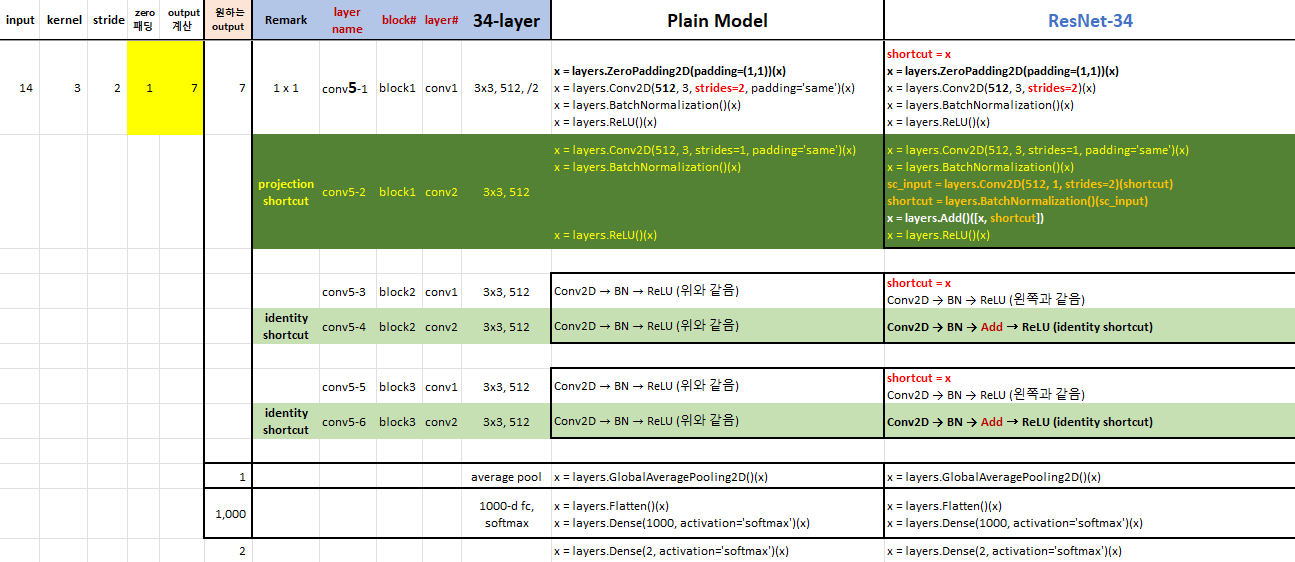

#### [ResNet-34 특성 정리] 

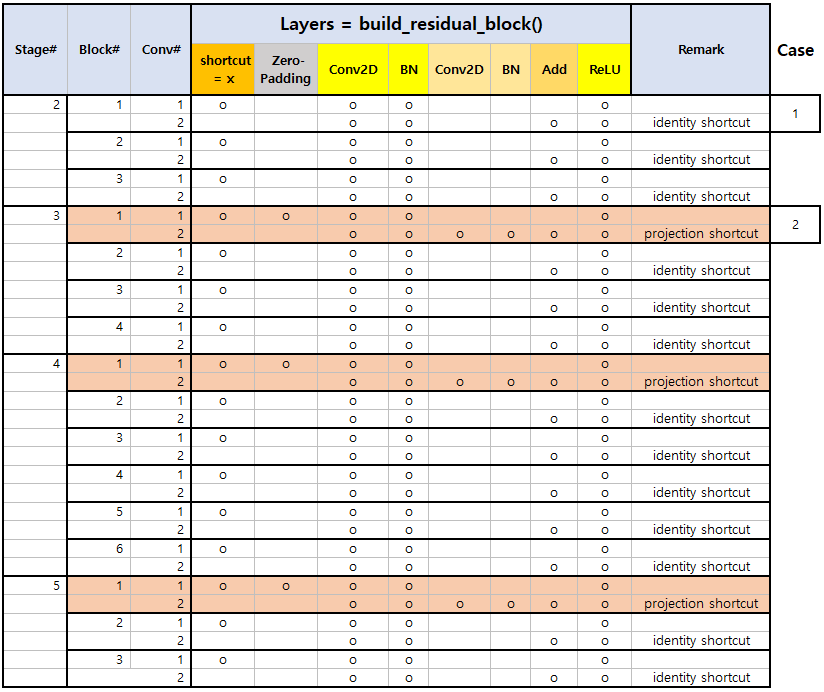

- 위의 표에서 보는 바와 같이 크게 두 가지 경우 존재
  - Identity Shortcut이 적용되는 경우
  - Projection Shortcut이 적용되는 경우
  
- 이 두 가지를 기본 블록으로 구현하고, 이를 이용하여 ResNet 구현

#### [Identity Block 구현]

In [15]:
# function for building Identity Block

def identity_block(input_layer, is_resnet=True, is_50=False, filters=64):
    
    # 입력 레이어
    x = input_layer

    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_layer])
    x = layers.ReLU()(x)

    return x

#### [Projection Block 구현]

In [16]:
# function for building Projection Block

def projection_block(input_layer, is_resnet=True, is_50=False, filters=64):
    
    # 입력 레이어
    x = input_layer
    
    x = layers.ZeroPadding2D(padding=(1,1))(x)
    x = layers.Conv2D(filters, 3, strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(filters, 1, strides=2)(input_layer)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

- **Identity 블록 확인**
  - 입력 레이어: (32,32,3)
  - 입력 레이어를 인자로 받아 identity_block()은 블록의 레이어를 build하고 출력값을 얻을 수 있음
  - 케라스의 Model 클래스에서 input과 output을 정의해서 간단히 블록의 모델 확인

In [17]:
#resnet_input_layer = layers.Input(shape=(32,32,3))   # 입력 레이어 생성
#x = layers.ZeroPadding2D(padding=(3,3))(resnet_input_layer)
#x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.ReLU()(x)
#x = layers.ZeroPadding2D(padding=(1,1))(x)
#x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# ResNet-34 Projection 블록 확인
#resnet_34_identity_block = identity_block(x,is_50=False)

In [18]:
# 블록 1개짜리 Resnet-34 Indentity Block 모델 생성
#model = keras.Model(inputs=resnet_input_layer, outputs=resnet_34_identity_block)  

#model.summary()

- **Projection 블록 확인**
  - identity_block의 출력 결과를 입력 레이어로 받아 projection_block() 블록 모델 확인

In [19]:
# ResNet-34 Projection 블록 확인
#resnet_34_projection_block = projection_block(resnet_34_identity_block, is_50=False)

- **Identity 블록에서 Projection 블록으로 연결되는 모델 확인**
  - 각각의 블록 1개로 구성된 가장 단순한 Resnet-34 [Identity + Projection] Block 모델 생성

In [20]:
# 블록 1개짜리 Resnet-34 [Identity + Projection] Block 모델 생성
#model = keras.Model(inputs=resnet_input_layer, outputs=resnet_34_projection_block)  

#model.summary()

## 2) ResNet-34, ResNet-50 Complete Model
> ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

### ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

#### [ResNet-34 모델 구성]

- 모델은 "Stage-Block-Conv"로 구성
  - Stage 번호: 2, 3, 4, 5
  - Block 수: 각 Stage별 블록 수... block_num_list=[3,4,6,3]
  - Filter 수: 각 Stage별 필터 수... filter_num_list=[64,128,256,512]


In [21]:
# ResNet-34 모델 생성 함수

def build_resnet_34(input_shape=(32,32,3),
              block_num_list=[3,4,6,3],
              filter_num_list=[64,128,256,512],
              is_50=False,
              num_classes=2):
    
    assert len(block_num_list) == len(filter_num_list) # 모델을 만들기 전에 configuration list들의 길이가 같은지 확인
    
    input_layer = layers.Input(shape=input_shape)   # 입력 레이어 생성
    
    # Stage 1 (논문 5페이지 표1의 conv1 및 그 다음 레이어까지) 구현
    
    x = layers.ZeroPadding2D(padding=(3,3))(input_layer)     # input-output 차원을 맞추기 위해 필요
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)   # conv1 구현
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.ZeroPadding2D(padding=(1,1))(x)               # input-output 차원을 맞추기 위해 필요
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)  # 3x3 max pool, stride 2 구현

    # config list의 길이만큼 반복해서 블록 생성
    for stage_num in range(2,6):
        
        for b_i in range(block_num_list[stage_num - 2]):
            block_num = b_i + 1
            
            # Stage 3, 4, 5의 첫 번째 블록은 Projection 블록
            if stage_num != 2 and block_num == 1:
                print(stage_num, block_num, filter_num_list[stage_num - 2], "projection")
                x = projection_block(x, filters=filter_num_list[stage_num - 2])
                
            # 이외의 블록은 Identity 블럭
            else:
                print(stage_num, block_num, filter_num_list[stage_num - 2], "identity")
                x = identity_block(x, filters=filter_num_list[stage_num - 2])
                
                
    x = layers.GlobalAveragePooling2D(name='GlobalAvgPool')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(1000, activation='softmax', name='1000d_fc')(x)
    x = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
   
    model = keras.Model(inputs=input_layer, outputs=x)
    
    return model

#### [ResNet-34 모델 생성]
  - 기본값을 그대로 사용해서 ResNet-34 모델 생성

In [22]:
# 기본값을 그대로 사용해서 ResNet-34 모델 생성
#resnet_34 = build_resnet_34() 
#resnet_34.summary()

### ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

### 분석 결과

#### [Stage 1&2]
- ResNet-34의 경우 Stage #2의 첫 번째 블록이 Identity 블록이었으나 <br> ResNet-50은 Projection 블록이다.

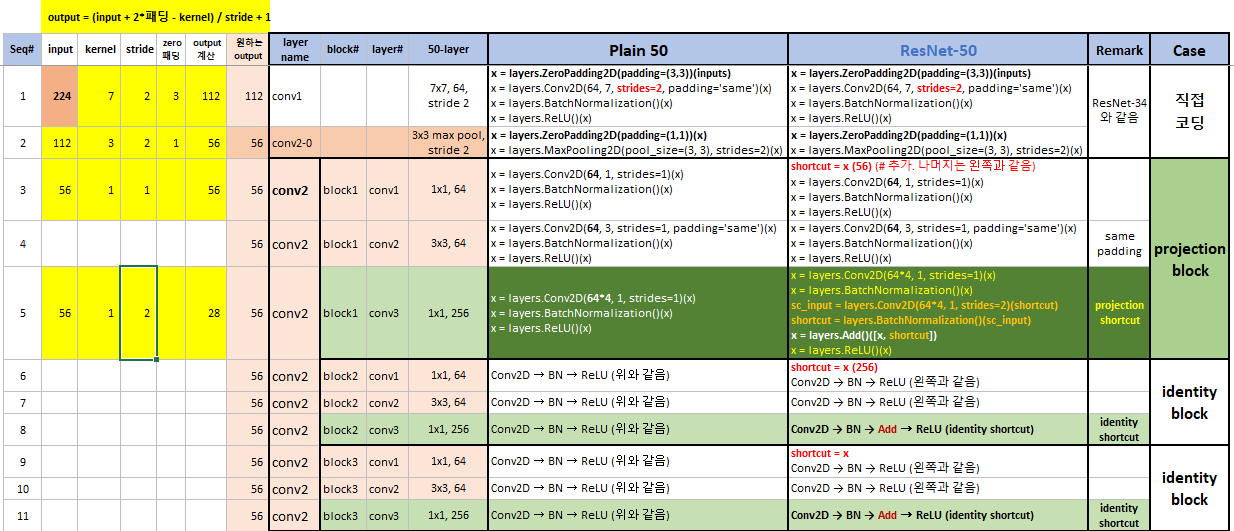


#### [Stage 3]
- ResNet-34의 경우 첫 번째 블럭 첫 번째 레이어로 제로패딩(x = layers.ZeroPadding2D(padding=(1,1))(x))이 필요했으나 <br> ResNet-50의 경우에는 필요없다.
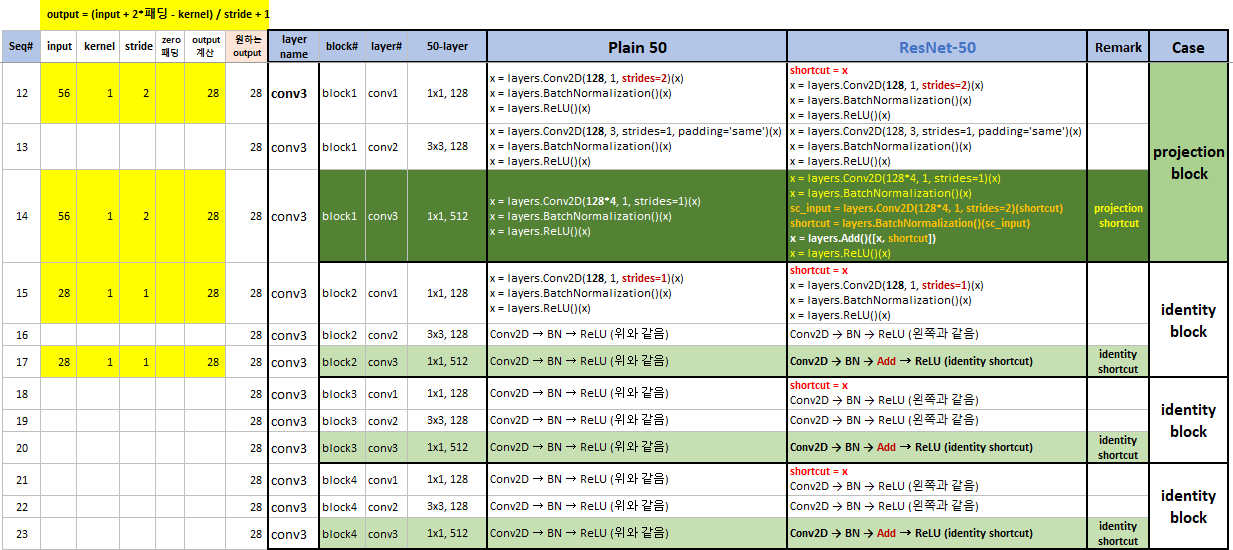

#### [Stage 4]
- ResNet-34의 경우 첫 번째 블럭 첫 번째 레이어로 제로패딩(x = layers.ZeroPadding2D(padding=(1,1))(x))이 필요했으나 <br> ResNet-50의 경우에는 필요없다.
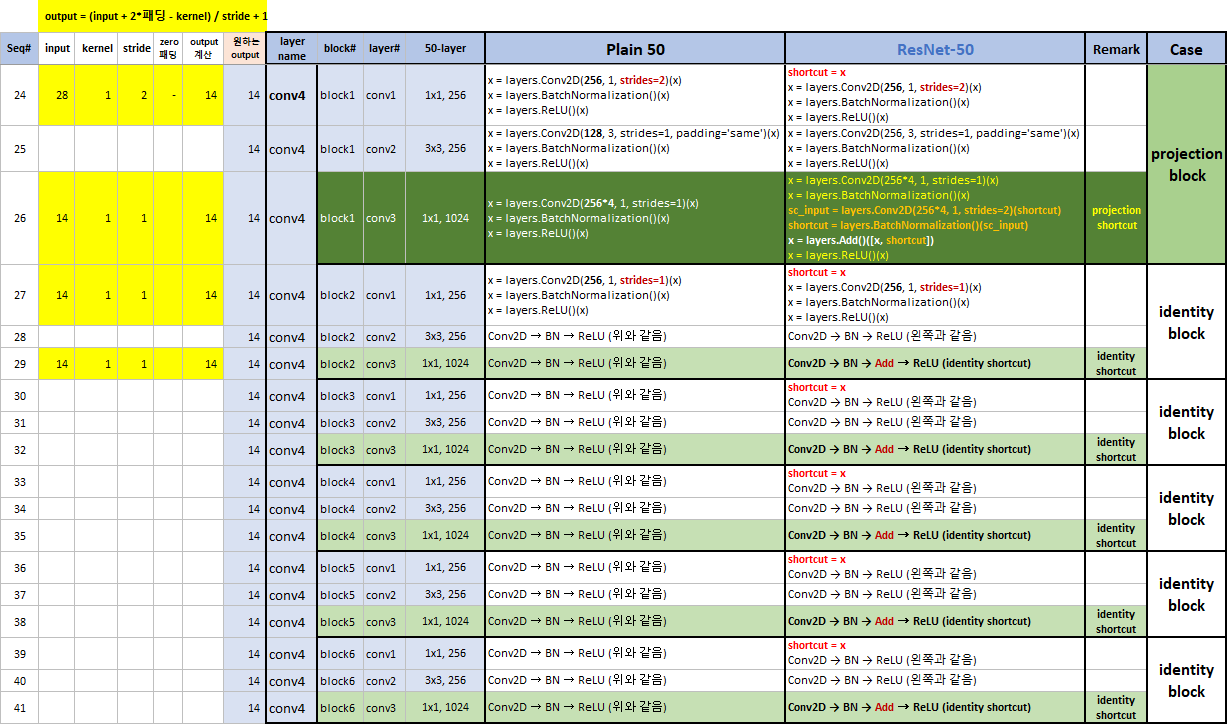

#### [Stage 5]
- ResNet-34의 경우 첫 번째 블럭 첫 번째 레이어로 제로패딩(x = layers.ZeroPadding2D(padding=(1,1))(x))이 필요했으나 <br> ResNet-50의 경우에는 필요없다.

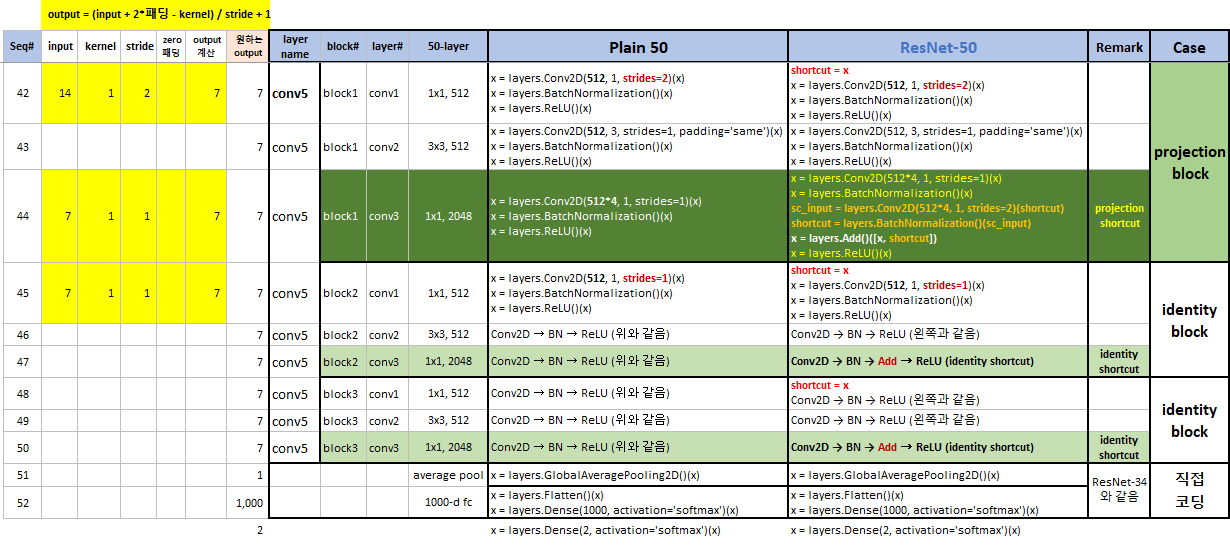

### [ResNet-34 vs. ResNet-50 Building Block 비교]

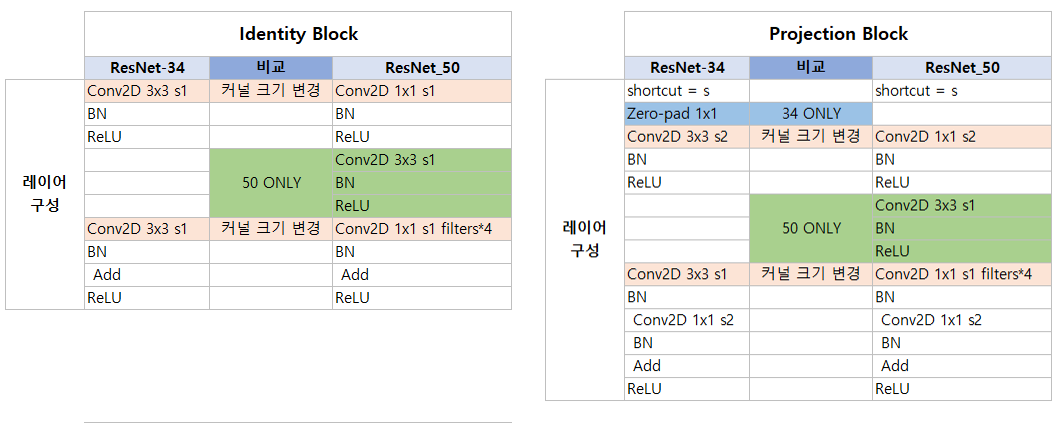


#### [general_Identity_block 구현]
- is_50 파라미터를 사용하여 ResNet-34, ResNet-50에 일반화된 부분 추가
- is_resnet 파라미터를 사용하여 Plain Net와 Resnet에 일반화된 부분 추가

In [23]:
# function for building General Identity Block

def general_identity_block(input_layer, is_resnet=True, is_50=False, filters=64):
    
    # 입력 레이어
    x = input_layer
    
    # 첫 번째 레이어
    if is_50:
        x = layers.Conv2D(filters, 1, strides=1)(x)
    else:
        x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
        
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # 두 번째 레이어: 50층 네트워크만 해당
    if is_50:
        x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    # 마지막 레이어
    if is_50:                             # 50층 네크워크는 커널크기=1, 필터 수가 4배
        new_filters = filters * 4
        x = layers.Conv2D(new_filters, 1, strides=1)(x)
        
    else:                                 # 34층 네트워크는 커널크기=3, 필터 수는 불변
        x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
   
    x = layers.BatchNormalization()(x)
    
    if is_resnet:                         # ResNet만 해당
        x = layers.Add()([x, input_layer]) # identity shortcut 실행 코드
    
    x = layers.ReLU()(x)

    return x

#### [general_projection_block 구현]
- is_50 파라미터를 사용하여 ResNet-34, ResNet-50에 일반화된 부분 추가
- is_resnet 파라미터를 사용하여 Plain Net와 Resnet에 일반화된 부분 추가

In [24]:
# function for building General Projection Block

def general_projection_block(input_layer, is_resnet=True, is_50=False, filters=64):
    
    # 입력 레이어
    x = input_layer
    
    # 50층 네크워크 마지막 레이어는 필터 수가 4배
    new_filters = filters * 4
    
    # 첫 번째 레이어
    if  not is_50:
        x = layers.ZeroPadding2D(padding=(1,1))(x)  # ResNet-34에서만 실행
    
    # 첫 번째 레이어
    if is_50:
        x = layers.Conv2D(filters, 1, strides=2)(x)
    else:
        x = layers.Conv2D(filters, 3, strides=2)(x)
        
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # 두 번째 레이어: 50층 네트워크만 해당
    if is_50:
        x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # 마지막 레이어
    if is_50:                             # 50층 네크워크는 커널크기=1, 필터 수가 4배
        x = layers.Conv2D(new_filters, 1, strides=1)(x)
    else:                                 # 34층 네트워크는 커널크기=3, 필터 수는 불변
        x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)

    x = layers.BatchNormalization()(x)

    if is_resnet:                         # ResNet만 해당
        shortcut = layers.Conv2D(filters, 1, strides=2)(input_layer) # projection shortcut 실행 코드
        shortcut = layers.BatchNormalization()(shortcut)             # projection shortcut 실행 코드
        x = layers.Add()([x, shortcut])                              # projection shortcut 실행 코드
        
    x = layers.ReLU()(x)

    return x

### <span style="color:blue">▶ 일반화된 최종 모델 구성</span>

- **general_identity_block(input_layer, is_resnet=True, is_50=False, filters=64):**
  - input_layer: 입력 레이어
  - is_resnet: ResNet, Plain Net 구분
  - is_50: 네트워크 레이어 34, 50 구분
  - filters: COnvolution 레이어의 필터 수. build_resnet에서 call할 때 정해짐
  <br> <br>
- **general_projection_block(input_layer, is_resnet=True, is_50=False, filters=64):**
  - input_layer: 입력 레이어
  - is_resnet: ResNet, Plain Net 구분
  - is_50: 네트워크 레이어 34, 50 구분
  - filters: COnvolution 레이어의 필터 수. build_resnet에서 call할 때 정해짐
  <br> <br>
- **build_resnet(input_shape=(32,32,3), block_num_list=[3,4,6,3], filter_num_list=[64,128,256,512], is_resnet=True, is_50=False, num_classes=2):**
  - input_shape=(32,32,3): 입력 레이어의 크기
  - block_num_list=[3,4,6,3]: 네트워크의 스테이지별 블록 수
  - filter_num_list=[64,128,256,512]: 네트워크의 스테이지별 필터 수
  - is_resnet: ResNet, Plain Net 구분
  - is_50: 네트워크 레이어 34, 50 구분
  - num_classes=2: 최종 분류의 클래스 수

In [25]:
# 일반화된 Network 모델 생성 함수

def build_resnet(input_shape=(32,32,3), block_num_list=[3,4,6,3], filter_num_list=[64,128,256,512],
                 is_resnet=True, is_50=False, num_classes=2):
    
    assert len(block_num_list) == len(filter_num_list) # 모델을 만들기 전에 configuration list들의 길이가 같은지 확인
    
    input_layer = layers.Input(shape=input_shape)   # 입력 레이어 생성
    
    # Stage 1 (논문 5페이지 표1의 conv1 및 그 다음 레이어까지) 구현
    
    x = layers.ZeroPadding2D(padding=(3,3))(input_layer)     # input-output 차원을 맞추기 위해 필요
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)   # conv1 구현
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.ZeroPadding2D(padding=(1,1))(x)               # input-output 차원을 맞추기 위해 필요
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)  # 3x3 max pool, stride 2 구현
    
    if not is_50:

        # config list의 길이만큼 반복해서 블록 생성
        for stage_num in range(2,6):
        
            for b_i in range(block_num_list[stage_num - 2]):
                block_num = b_i + 1
            
                # Stage 3, 4, 5의 첫 번째 블록은 Projection 블록
                if stage_num != 2 and block_num == 1:
                    print(stage_num, block_num, filter_num_list[stage_num - 2], "projection")
                    x = projection_block(x, filters=filter_num_list[stage_num - 2])
                
                # 이외의 블록은 Identity 블럭
                else:
                    print(stage_num, block_num, filter_num_list[stage_num - 2], "identity")
                    x = identity_block(x, filters=filter_num_list[stage_num - 2])
    
    else:
        
        # config list의 길이만큼 반복해서 블록 생성
        for stage_num in range(2,6):
        
            for b_i in range(block_num_list[stage_num - 2]):
                block_num = b_i + 1
            
                # 첫 번째 블록은 Projection 블록
                if block_num == 1:
                    print(stage_num, block_num, filter_num_list[stage_num - 2], "projection")
                    x = projection_block(x, filters=filter_num_list[stage_num - 2])
                
                # 이외의 블록은 Identity 블럭
                else:
                    print(stage_num, block_num, filter_num_list[stage_num - 2], "identity")
                    x = identity_block(x, filters=filter_num_list[stage_num - 2])
    
    x = layers.GlobalAveragePooling2D(name='GlobalAvgPool')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(1000, activation='softmax', name='1000d_fc')(x)
    x = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
   
    model = keras.Model(inputs=input_layer, outputs=x)
    
    return model

#### [일반화한 함수를 이용한 ResNet-34 모델 구성]
- build_resnet(input_shape=(32,32,3), block_num_list=[3,4,6,3], filter_num_list=[64,128,256,512],<br> is_resnet=True, is_50=False, num_classes=2)

In [26]:
#resnet_34 = build_resnet(input_shape=(224,224,3), is_resnet=True, is_50=False, num_classes=2)
resnet_34 = build_resnet(input_shape=(32,32,3), is_resnet=True, is_50=False, num_classes=10)
resnet_34.summary()

2 1 64 identity
2 2 64 identity
2 3 64 identity
3 1 128 projection
3 2 128 identity
3 3 128 identity
3 4 128 identity
4 1 256 projection
4 2 256 identity
4 3 256 identity
4 4 256 identity
4 5 256 identity
4 6 256 identity
5 1 512 projection
5 2 512 identity
5 3 512 identity
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 19, 19, 64)   9472        zero_padding2d[0][0]             
_________________

#### [일반화한 함수를 이용한 ResNet-50 모델 구성]
- build_resnet(input_shape=(32,32,3), block_num_list=[3,4,6,3], filter_num_list=[64,128,256,512],<br> is_resnet=True, is_50=False, num_classes=2)

In [27]:
#resnet_50 = build_resnet(input_shape=(224,224,3), is_resnet=True, is_50=True, num_classes=2)
resnet_50 = build_resnet(input_shape=(32,32,3), is_resnet=True, is_50=True, num_classes=10)
resnet_50.summary()

2 1 64 projection
2 2 64 identity
2 3 64 identity
3 1 128 projection
3 2 128 identity
3 3 128 identity
3 4 128 identity
4 1 256 projection
4 2 256 identity
4 3 256 identity
4 4 256 identity
4 5 256 identity
4 6 256 identity
5 1 512 projection
5 2 512 identity
5 3 512 identity
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 19, 19, 64)   9472        zero_padding2d_5[0][0]           
_____________

__________________________________________________________________________________________________
re_lu_61 (ReLU)                 (None, 1, 1, 512)    0           add_29[0][0]                     
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 1, 1, 512)    2359808     re_lu_61[0][0]                   
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 1, 1, 512)    2048        conv2d_69[0][0]                  
__________________________________________________________________________________________________
re_lu_62 (ReLU)                 (None, 1, 1, 512)    0           batch_normalization_69[0][0]     
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 1, 1, 512)    2359808     re_lu_62[0][0]                   
__________

## 3) 일반 네트워크(plain network) 만들기
### 블록 코드 수정하기
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

### 전체 함수 코드 수정하기
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

#### [일반화한 함수를 이용한 PlainNet-50 모델 구성]
- build_resnet(input_shape=(32,32,3), block_num_list=[3,4,6,3], filter_num_list=[64,128,256,512],<br> is_resnet=True, is_50=False, num_classes=2)

In [28]:
#plainnet_50 = build_resnet(input_shape=(224,224,3),is_resnet=False, is_50=True, num_classes=2)
plainnet_50 = build_resnet(input_shape=(32,32,3),is_resnet=False, is_50=True, num_classes=10)
plainnet_50.summary()

2 1 64 projection
2 2 64 identity
2 3 64 identity
3 1 128 projection
3 2 128 identity
3 3 128 identity
3 4 128 identity
4 1 256 projection
4 2 256 identity
4 3 256 identity
4 4 256 identity
4 5 256 identity
4 6 256 identity
5 1 512 projection
5 2 512 identity
5 3 512 identity
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 19, 19, 64)   9472        zero_padding2d_11[0][0]          
_____________

#### [일반화한 함수를 이용한 PlainNet-34 모델 구성]
- build_resnet(input_shape=(32,32,3), block_num_list=[3,4,6,3], filter_num_list=[64,128,256,512],<br> is_resnet=True, is_50=False, num_classes=2)

In [29]:
#plainnet_34 = build_resnet(input_shape=(224,224,3),is_resnet=False, is_50=False, num_classes=2)
plainnet_34 = build_resnet(input_shape=(32,32,3),is_resnet=False, is_50=False, num_classes=10)
plainnet_34.summary()

2 1 64 identity
2 2 64 identity
2 3 64 identity
3 1 128 projection
3 2 128 identity
3 3 128 identity
3 4 128 identity
4 1 256 projection
4 2 256 identity
4 3 256 identity
4 4 256 identity
4 5 256 identity
4 6 256 identity
5 1 512 projection
5 2 512 identity
5 3 512 identity
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 19, 19, 64)   9472        zero_padding2d_17[0][0]          
_______________

re_lu_125 (ReLU)                (None, 3, 3, 256)    0           add_60[0][0]                     
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 5, 5, 256)    0           re_lu_125[0][0]                  
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 2, 2, 512)    1180160     zero_padding2d_21[0][0]          
__________________________________________________________________________________________________
batch_normalization_139 (BatchN (None, 2, 2, 512)    2048        conv2d_139[0][0]                 
__________________________________________________________________________________________________
re_lu_126 (ReLU)                (None, 2, 2, 512)    0           batch_normalization_139[0][0]    
__________________________________________________________________________________________________
conv2d_140

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### Ablation Study
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

### 시각화
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

### 추가 실험
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.

[Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

In [30]:
#BATCH_SIZE = 256
EPOCH = 15

### [ResNet-50 훈련]

- 15 epoch 정도 (40 epoch 권장)


In [31]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 35s 100ms/step - loss: 2.3026 - accuracy: 0.1049 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 2/15
195/195 [==============================] - 17s 90ms/step - loss: 2.3022 - accuracy: 0.1223 - val_loss: 2.3026 - val_accuracy: 0.1031
Epoch 3/15
195/195 [==============================] - 18s 90ms/step - loss: 2.3017 - accuracy: 0.1400 - val_loss: 2.3023 - val_accuracy: 0.1254
Epoch 4/15
195/195 [==============================] - 18s 90ms/step - loss: 2.3007 - accuracy: 0.1543 - val_loss: 2.2998 - val_accuracy: 0.1656
Epoch 5/15
195/195 [==============================] - 18s 91ms/step - loss: 2.2984 - accuracy: 0.1775 - val_loss: 2.2952 - val_accuracy: 0.1910
Epoch 6/15
195/195 [==============================] - 18s 91ms/step - loss: 2.2929 - accuracy: 0.1822 - val_loss: 2.2884 - val_accuracy: 0.1884
Epoch 7/15
195/195 [==============================] - 18s 91ms/step - loss: 2.2831 - accuracy: 0.2103 - val_loss: 2.2794 - val_accuracy

### [PlainNet-50 훈련]

- 15 epoch 정도 (40 epoch 권장)


In [32]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 27s 93ms/step - loss: 2.3022 - accuracy: 0.1159 - val_loss: 2.3026 - val_accuracy: 0.0983
Epoch 2/15
195/195 [==============================] - 18s 90ms/step - loss: 2.3019 - accuracy: 0.1191 - val_loss: 2.3025 - val_accuracy: 0.1039
Epoch 3/15
195/195 [==============================] - 18s 91ms/step - loss: 2.3012 - accuracy: 0.1181 - val_loss: 2.3022 - val_accuracy: 0.1188
Epoch 4/15
195/195 [==============================] - 18s 90ms/step - loss: 2.3002 - accuracy: 0.1466 - val_loss: 2.3002 - val_accuracy: 0.1462
Epoch 5/15
195/195 [==============================] - 18s 90ms/step - loss: 2.2979 - accuracy: 0.1632 - val_loss: 2.2979 - val_accuracy: 0.1562
Epoch 6/15
195/195 [==============================] - 17s 89ms/step - loss: 2.2929 - accuracy: 0.1707 - val_loss: 2.2904 - val_accuracy: 0.1843
Epoch 7/15
195/195 [==============================] - 18s 90ms/step - loss: 2.2842 - accuracy: 0.1847 - val_loss: 2.2816 - val_accuracy:

### [ResNet-50 vs. PlainNet-50 비교 시각화]

- 훈련 손실(training loss) 비교

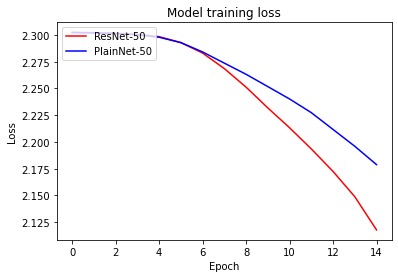

In [33]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plainnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'PlainNet-50'], loc='upper left')
plt.show()

- 검증 정확도(validation accuracy) 비교

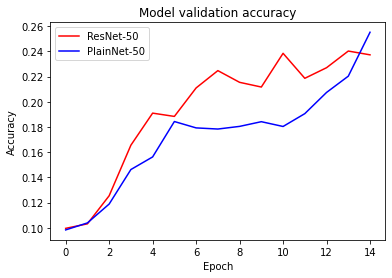

In [34]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plainnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'PlainNet-50'], loc='upper left')
plt.show()

### [ResNet-34 훈련]

- 15 epoch 정도 (40 epoch 권장)


In [35]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 39s 144ms/step - loss: 2.3025 - accuracy: 0.0989 - val_loss: 2.3026 - val_accuracy: 0.0972
Epoch 2/15
195/195 [==============================] - 27s 139ms/step - loss: 2.3023 - accuracy: 0.1006 - val_loss: 2.3026 - val_accuracy: 0.1068
Epoch 3/15
195/195 [==============================] - 27s 137ms/step - loss: 2.3020 - accuracy: 0.1176 - val_loss: 2.3024 - val_accuracy: 0.1240
Epoch 4/15
195/195 [==============================] - 27s 138ms/step - loss: 2.3012 - accuracy: 0.1051 - val_loss: 2.2990 - val_accuracy: 0.0999
Epoch 5/15
195/195 [==============================] - 27s 137ms/step - loss: 2.2974 - accuracy: 0.1214 - val_loss: 2.2919 - val_accuracy: 0.1327
Epoch 6/15
195/195 [==============================] - 27s 136ms/step - loss: 2.2882 - accuracy: 0.1634 - val_loss: 2.2851 - val_accuracy: 0.1714
Epoch 7/15
195/195 [==============================] - 27s 138ms/step - loss: 2.2734 - accuracy: 0.1701 - val_loss: 2.2687 - val_ac

### [PlainNet-34 훈련]

- 15 epoch 정도 (40 epoch 권장)


In [36]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 36s 139ms/step - loss: 2.3025 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.1036
Epoch 2/15
195/195 [==============================] - 27s 138ms/step - loss: 2.3023 - accuracy: 0.1016 - val_loss: 2.3026 - val_accuracy: 0.0974
Epoch 3/15
195/195 [==============================] - 27s 136ms/step - loss: 2.3020 - accuracy: 0.1157 - val_loss: 2.3025 - val_accuracy: 0.0950
Epoch 4/15
195/195 [==============================] - 26s 136ms/step - loss: 2.3015 - accuracy: 0.1190 - val_loss: 2.3014 - val_accuracy: 0.1401
Epoch 5/15
195/195 [==============================] - 27s 137ms/step - loss: 2.3005 - accuracy: 0.1289 - val_loss: 2.2997 - val_accuracy: 0.1278
Epoch 6/15
195/195 [==============================] - 27s 137ms/step - loss: 2.2979 - accuracy: 0.1586 - val_loss: 2.2965 - val_accuracy: 0.1640
Epoch 7/15
195/195 [==============================] - 27s 137ms/step - loss: 2.2916 - accuracy: 0.1705 - val_loss: 2.2898 - val_ac

### [ResNet-34 vs. PlainNet-34 비교 시각화]

- 훈련 손실(training loss) 비교

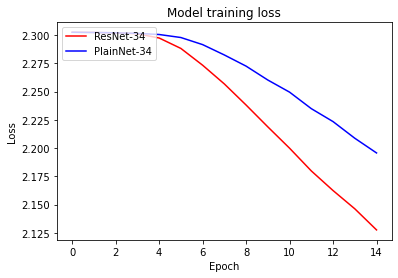

In [37]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plainnet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'PlainNet-34'], loc='upper left')
plt.show()

- 검증 정확도(validation accuracy) 비교

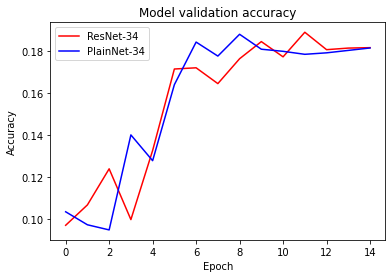

In [38]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plainnet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'PlainNet-34'], loc='upper left')
plt.show()

### [Ablation Study]

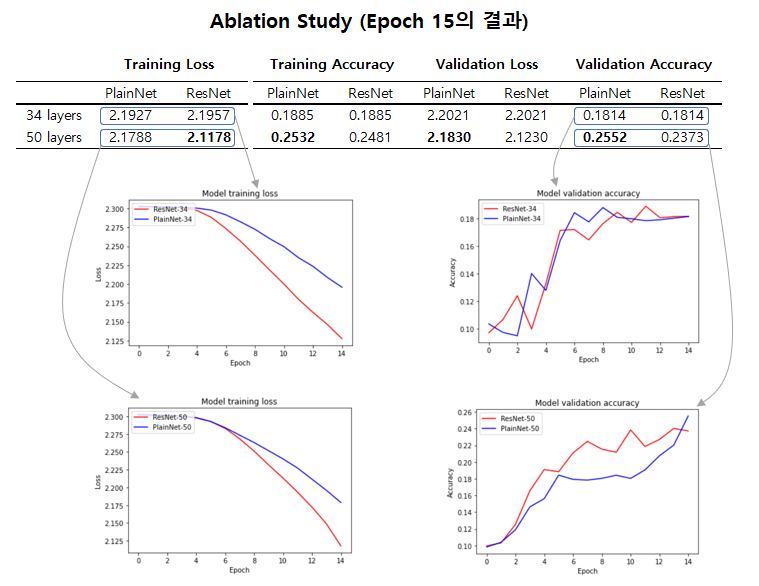

#### [Training Loss]
  - (Plain vs ResNet) 두 레이어에 모두에서 **ResNet**의 감소 속도가 빠름을 보여준다.
  - (34 v4 50 레이어) 두 모델 모두에서 **50** 레이어 모델 값이 더 작음을 보여준다.
  
  → **ResNet-50**의 값이 가장 우수하다.
  
#### [Validation Accuracy]
  - (Plain vs ResNet) 두 레이어에 모두에서 **ResNet**의 정확도가 같거나 높음을 보여준다.
  - (34 v4 50 레이어) 두 모델 모두에서 **50** 레이어 모델의 정확도가 같거나 높음을 보여준다.
    - Epoch 15에서는 PlainNet-50이 가장 좋으나 그래프를 보면 ResNet-50이 더 좋을 것으로 예상된다.
    
  → **ResNet-50**의 값이 가장 우수할 것으로 예상된다.
  
#### [종합]
  - 논문에서 제시한 바와 같이, ResNet이 일반 네트워크보다 우수하며
  - ResNet에서는 레이어 수가 많은 것이 우수하다.
    - 논문에서 제시한 바와 같아 레이어 수가 많음에도 불구하고 최적화 해야 하는 파라미터 수는 비슷하여 컴퓨팅 자원 소모는 유사하다.
    - 실행 결과는 34 레이어(27초 정도/epoch)의 경우가 50 레이어(18초 정도/epoch)보다 실행 기간이 길었다.
  - 위의 결과는 시험적으로 적은 데이터셋으로 소수의 epoch만을 실행한 것이므로 이를 기준으로 일반화할 수는 없다.
  - 그러나 논문에서 주장한 바를 목격할 수는 있다...
  

# 프로젝트 평가

| 평가문항 | 상세기준 | 수행 결과 | 
|:---|:---|:---|
| 1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다. | 완료. 2), 3) 부분 참고 |
| 2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다. | 완료. cats_vs_dogs 데이터셋 구성에 에러가 있어 CIFAR10 데이터셋 사용 |
| 3. Ablation Study 결과가 바른 포맷으로 제출되었는가? | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. | 완료. 4) 부분 참고 |



### 프로젝트 코드 순서

※ cats_vs_dogs 데이터셋 준비하기  
※ Input Normalization
   - 에러 발생으로 CIFAR10 데이터셋 사용

0) 라이브러리 버전 확인하기

1) ResNet 기본 블록 구성하기
  - Identity Block 구현
  - Projection Block 구현

2) ResNet-34, ResNet-50 Complete Model
  - ResNet-34
  - ResNet-50
  - ResNet-34 vs. ResNet-50 Building Block 비교
  - General Identity Block 구현
  - General Projection Block 구현
  - 일반화된 최종 모델 구성

3) 일반 네트워크(plain network) 만들기
  - 일반화한 함수를 이용한 PlainNet-50 모델 구성
  - 일반화한 함수를 이용한 PlainNet-34 모델 구성

4) ResNet-50 vs. Plain-50 또는 ResNet-34 vs. Plain-34
  - ResNet-50 훈련
  - PlainNet-50 훈련
  - ResNet-50 vs. PlainNet-50 비교 시각화
  - ResNet-34 훈련
  - PlainNet-34 훈련
  - ResNet-34 vs. PlainNet-34 비교 시각화
  - Ablation Study 결과


### [회고]
1. 남들이 해놓은 것 복붙 수준으로 하다가 직접 해보려니 엄두가 나지 않았다.
2. 많은 사람들, 특히 퍼실님과 의 도움을 받아 그래도 꾸역꾸역 해냈다.
3. 그런데 이게 맞다고 어떻게 보장할 수 있을까?
4. cats_vs_dogs 데이터셋을 사용하고 이미지 크기를 224x224로 해보았으나 에러가 발생하였다.
   - 원인 파악은 안되고 기한은 다가오고... 할 수 없이 CIFAR-10 데이터셋을 사용했다.
   - 남겨진 숙제다. 리사이즈, 배치 사이즈 등과 관련된 문제인 것으로 파악된다.
   - 모르는 게 너무 많다.
5. 시간이 더 주어진다면 더 잘 할 수도 있을 지도
6. 모르는 것들을 해결하지 못하고 피해가거나 덮고 지나갈 수 밖에 없어서...
7. identity block과 projection block 일반화도 보다 효과적으로 할 수 있을텐데...
8. 아래 코드는 만들다가 에러가 나서 일단 좀 무식한(?) 방법으로 끝냈다.
   - 모든 경우를 거를 수 있도록 조건문을 정확하게 만들지 못한 것 같다.
   - 파라미터가 여러 개가 조건으로 엮이니까...

In [ ]:
   
"""    
    # config list의 길이만큼 반복해서 블록 생성
    for stage_num in range(2,6):
        
        for b_i in range(block_num_list[stage_num - 2]):
            block_num = b_i + 1
            
            # 첫 번째 블록은 Projection 블록
            # general_projection_block(input_layer, is_resnet=True, is_50=False, filters=64)
            
            if block_num == 1:
                
                # 34층 네트워크의 Stage #2의 경우는 Identity 블록
                if not is_50 and stage_num == 2:
                    
                    print("50:",is_50, "ResNet:", is_resnet, stage_num, block_num, filter_num_list[stage_num - 2], "identity")
                    x = general_identity_block(x, is_resnet, is_50, filters=filter_num_list[stage_num - 2])
                    
                else:
                    print("50:",is_50, "ResNet:", is_resnet, stage_num, block_num, filter_num_list[stage_num - 2], "projection")
                    x = general_projection_block(x, is_resnet, is_50, filters=filter_num_list[stage_num - 2])
                
            # 이외의 블록은 Identity 블럭
            # general_identity_block(input_layer, is_resnet=True, is_50=False, filters=64)
            
            else:
                
                print("50:",is_50, "ResNet:", is_resnet, stage_num, block_num, filter_num_list[stage_num - 2], "identity")
                x = general_identity_block(x, is_resnet, is_50, filters=filter_num_list[stage_num - 2])
                
"""   